In [4]:
import torch
import os
import PlotModule
import matplotlib.pyplot as plt
from Model.PyTorch_CIFAR10.cifar10_models.resnet import resnet18

vanilla_model = resnet18(pretrained=True)

folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'local_pruned_model.pth'
dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
pruned_model = torch.load(f'{folder_path}/{model_name}')

folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = '/FineTuning/best_model.pth'
dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
finetuned_model = torch.load(f'{folder_path}/{model_name}', map_location="cpu")

## conductance distribution

Min Nonzero Gp (FC): 0.011895670555531979, Min Nonzero Gm (FC): 0.014217847026884556
Min Nonzero Gp (Conv): 1.1238326180773583e-07, Min Nonzero Gm (Conv): 9.361220776327173e-08


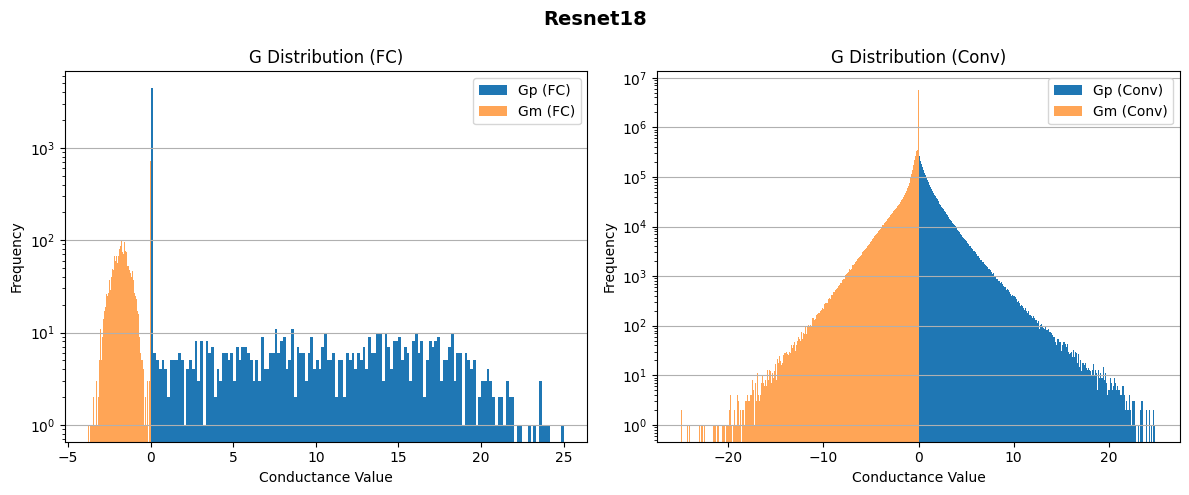

In [2]:
model_vanilla = resnet18(pretrained=True)
PlotModule.plot_conductance_distribution(model_vanilla, 'Resnet18', True, True)

Min Nonzero Gp (FC): 2.2370553016662598, Min Nonzero Gm (FC): 2.2239603996276855
Min Nonzero Gp (Conv): 0.44036930799484253, Min Nonzero Gm (Conv): 0.44036737084388733


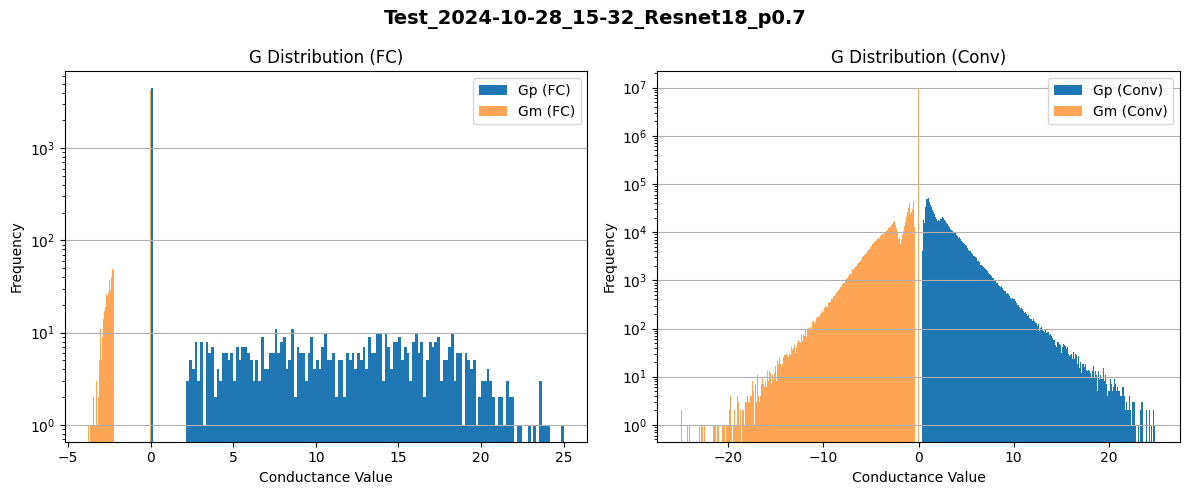

In [4]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'local_pruned_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
pruned_model = torch.load(f'{folder_path}/{model_name}')

PlotModule.plot_conductance_distribution(pruned_model, folder_name, True, True)

Min Nonzero Gp (FC): 0.0012116378638893366, Min Nonzero Gm (FC): 2.826629497576505e-06
Min Nonzero Gp (Conv): 2.1019476964872256e-42, Min Nonzero Gm (Conv): 4.414090162623174e-42


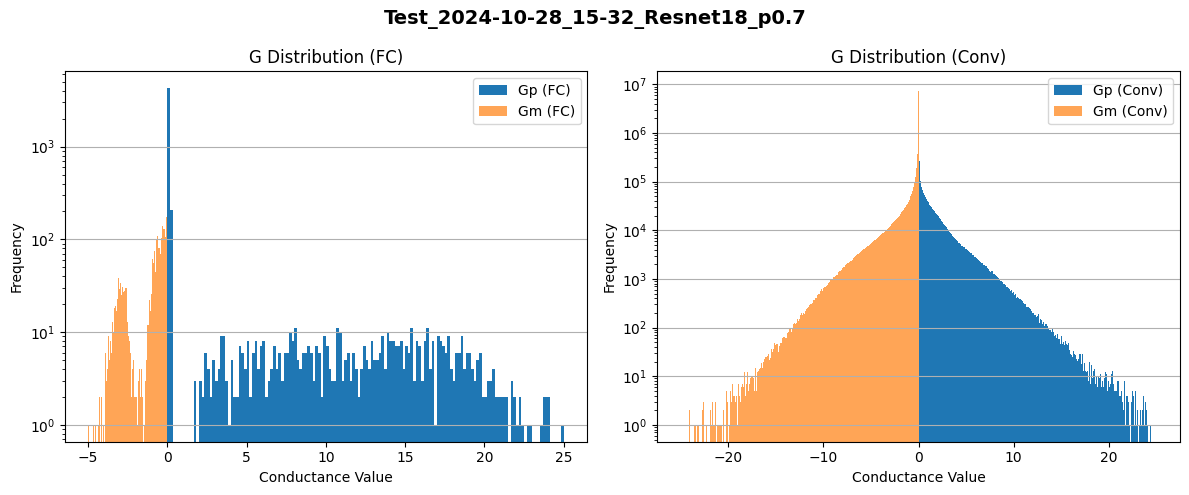

In [2]:
PlotModule.plot_conductance_distribution(finetuned_model, folder_name, True, True)

## 특정 module만 그리기

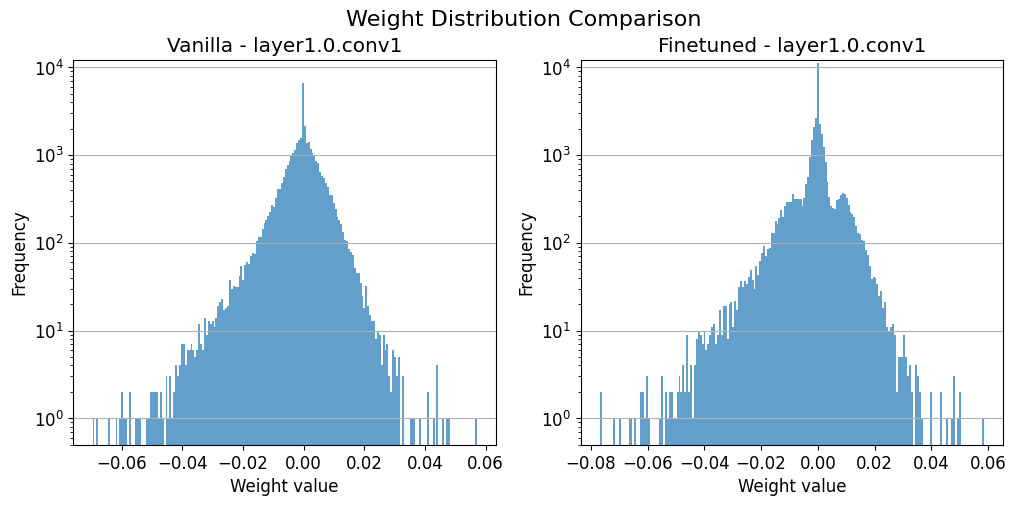

In [36]:
plot_weight_comparison(model_vanilla, finetuned_model, 'layer1.0.conv1')

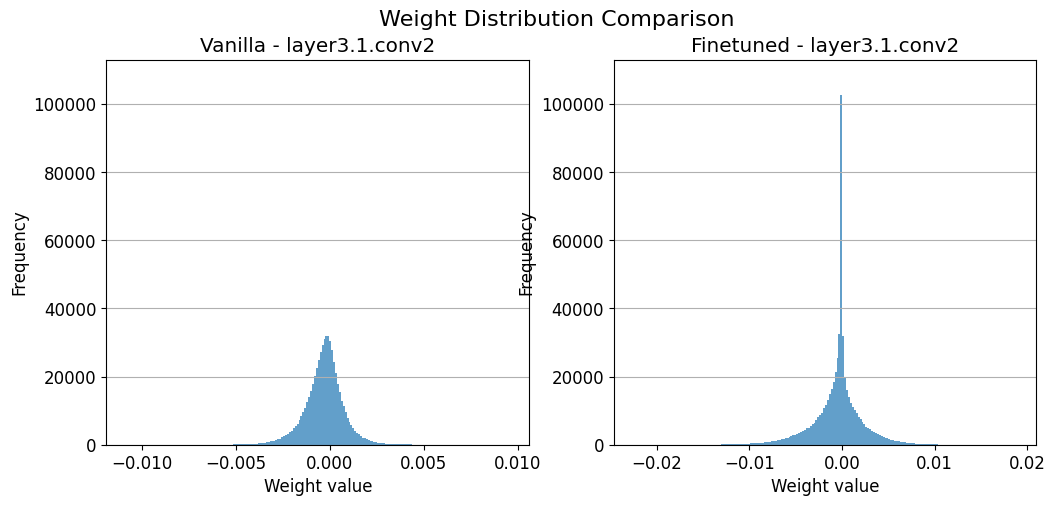

In [46]:
plot_weight_comparison(model_vanilla, finetuned_model, 'layer3.1.conv2')

## weight 저장

In [40]:
import scipy
def save_weights_for_matlab(model, layer_name, filename="weights.mat"):
    """Extracts weights from a specific layer and saves them in a .mat file for MATLAB."""
    weights = None
    for name, param in model.named_parameters():
        if layer_name in name:
            weights = param.data.cpu().numpy().flatten()  # 1D 배열로 변환
            break
    
    if weights is not None:
        scipy.io.savemat(filename, {"weights": weights})
        print(f"Saved weights to {filename}")
    else:
        print("Layer not found!")

In [47]:
save_weights_for_matlab(model_vanilla, "layer3.1.conv2.weight", "3.1.2.vanilla_weights.mat")
save_weights_for_matlab(pruned_model, "layer3.1.conv2.weight", "3.1.2.pruned_weights.mat")
save_weights_for_matlab(finetuned_model, "layer3.1.conv2.weight", "3.1.2.finetuned_weights.mat")

Saved weights to 3.1.2.vanilla_weights.mat
Saved weights to 3.1.2.pruned_weights.mat
Saved weights to 3.1.2.finetuned_weights.mat


## aihwkit G change 함수

In [247]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from network import InfModel

def compute_total_drift_error(model, dataset, gdc=True, ideal_io=True, t_seconds=3600*24*7):
    """
    전체 모델 weight를 analog로 변환하고,
    드리프트를 적용한 후 초기 conductance와의 차이를 계산합니다.
    """
    inf_model = InfModel(model, dataset, noise_list=[0,0])
    rpu_config = inf_model.SetConfig(gdc=gdc, ideal_io=ideal_io)
    analog_model = inf_model.ConvertModel(gdc=gdc, ideal_io=ideal_io)

    noise_model = rpu_config.noise_model
    g_converter = noise_model.g_converter

    all_g_init = []
    all_g_drifted = []
    all_delta_g = []
    total_drift_error = 0.0
    total_drift_error_ratio = 0.0
    total_g_init = 0.0
    total_g_drifted = 0.0
    total_nu = 0.0

    for name, param in analog_model.named_parameters():
        if "weight" in name and len(param.size()) > 1:
            weights = param.data.cpu()

            # Conductance 변환
            (gp, gm), _ = g_converter.convert_to_conductances(weights)

            # Programming noise (optional, realistic)
            gp_prog = noise_model.apply_programming_noise_to_conductance(gp)
            gm_prog = noise_model.apply_programming_noise_to_conductance(gm)
            # gp_prog = gp
            # gm_prog = gm

            # Drift coefficient 생성
            nu_gp = noise_model.generate_drift_coefficients(gp_prog)
            nu_gm = noise_model.generate_drift_coefficients(gm_prog)
            total_nu += torch.sum(nu_gp).item() + torch.sum(nu_gm).item()

            # Drift 적용
            gp_drifted = noise_model.apply_drift_noise_to_conductance(gp_prog, nu_gp, t_seconds)
            gm_drifted = noise_model.apply_drift_noise_to_conductance(gm_prog, nu_gm, t_seconds)


            # ΔG 계산
            g_init = gp_prog - gm_prog
            g_drifted = gp_drifted - gm_drifted
            delta_g = torch.abs(g_init - g_drifted)
            # delta_g_ratio = torch.abs(delta_g / g_init)
            
            all_g_init.append(g_init.flatten())
            all_g_drifted.append(g_drifted.flatten())
            all_delta_g.append(delta_g.flatten())
            
            # total drift error
            drift_error = torch.sum(torch.abs(g_init - g_drifted)).item()
            total_drift_error += drift_error
            
            # total conductance
            total_g_init += torch.sum(g_init).item()
            total_g_drifted += torch.sum(g_drifted).item()

            # exclude zero conductance
            nonzero_mask = g_init != 0
            drift_error_ratio = torch.sum(delta_g[nonzero_mask] / g_init[nonzero_mask].abs()).item()
            total_drift_error_ratio += drift_error_ratio
            
    # 전체 G 및 ΔG 모으기
    g_init_all = torch.cat(all_g_init).numpy()
    g_drifted_all = torch.cat(all_g_drifted).numpy()
    delta_g_all = torch.cat(all_delta_g).numpy()
    
    # for global drift compensation
    alpha = total_g_drifted / total_g_init
    total_drift_error_ratio_gdc = total_drift_error_ratio * alpha
    
    
    # ==== 출력: 통계 요약 ====
    print("[TOTAL DRIFT STATS]")
    print(f"ΔG mean: {delta_g_all.mean():.6f}")
    print(f"ΔG std : {delta_g_all.std():.6f}")
    print(f"ΔG max : {delta_g_all.max():.6f}")
    print(f"ΔG 99th percentile: {np.percentile(delta_g_all, 99):.6f}")
    print(f"Total drift error after {t_seconds}sec: {total_drift_error:.4e}")
    print(f"Total drift error ratio after {t_seconds}sec: {total_drift_error_ratio:.4e}")
    print(f"alpha: {alpha:.6f}")
    print(f"Total drift error ratio after {t_seconds}sec (GDC): {total_drift_error_ratio_gdc:.4e}")
    print(f"sum_nu: {total_nu:.4e}")


In [248]:
t_seconds = 9.33e7
compute_total_drift_error(finetuned_model, dataset="cifar10", t_seconds=t_seconds)

[TOTAL DRIFT STATS]
ΔG mean: 0.500356
ΔG std : 0.863082
ΔG max : 12.052124
ΔG 99th percentile: 3.932515
Total drift error after 93300000.0sec: 5.5862e+06
Total drift error ratio after 93300000.0sec: 7.4704e+06
alpha: 0.440642
Total drift error ratio after 93300000.0sec (GDC): 3.2918e+06
sum_nu: 2.0659e+06


In [249]:
compute_total_drift_error(model_vanilla, dataset="cifar10", t_seconds=t_seconds)

[TOTAL DRIFT STATS]
ΔG mean: 0.676451
ΔG std : 0.787085
ΔG max : 12.166088
ΔG 99th percentile: 3.594393
Total drift error after 93300000.0sec: 7.5521e+06
Total drift error ratio after 93300000.0sec: 7.1189e+06
alpha: 0.550565
Total drift error ratio after 93300000.0sec (GDC): 3.9194e+06
sum_nu: 1.9761e+06


In [131]:
compute_total_drift_error(pruned_model, dataset="cifar10", t_seconds=t_seconds)

[TOTAL DRIFT STATS]
ΔG mean: 0.416274
ΔG std : 0.833823
ΔG max : 13.499674
ΔG 99th percentile: 3.595491
Total drift error after 93300000.0sec: 4.6474e+06
Total drift error ratio after 93300000.0sec: 1.9439e+06


In [232]:
folder_name = 'Test_2024-10-28_15-15_Resnet18_p0.3'
model_name = '/FineTuning/best_model.pth'
dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
tuning_model = torch.load(f'{folder_path}/{model_name}', map_location="cpu")

# compute_total_drift_error(tuning_model, dataset="cifar10", t_seconds=t_seconds)

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def compute_and_plot_network_drift(model, dataset, gdc=True, ideal_io=True, t_seconds=3600*24*7):
    inf_model = InfModel(model, dataset, noise_list=[0, 0])
    rpu_config = inf_model.SetConfig(gdc=gdc, ideal_io=ideal_io)
    analog_model = inf_model.ConvertModel(gdc=gdc, ideal_io=ideal_io)

    noise_model = rpu_config.noise_model
    g_converter = noise_model.g_converter

    all_g_init = []
    all_g_drifted = []
    all_delta_g = []

    for name, param in analog_model.named_parameters():
        if "weight" in name and len(param.size()) > 1:
            weights = param.data.cpu()

            (gp, gm), _ = g_converter.convert_to_conductances(weights)

            gp_prog = noise_model.apply_programming_noise_to_conductance(gp)
            gm_prog = noise_model.apply_programming_noise_to_conductance(gm)

            nu_gp = noise_model.generate_drift_coefficients(gp_prog)
            nu_gm = noise_model.generate_drift_coefficients(gm_prog)

            gp_drifted = noise_model.apply_drift_noise_to_conductance(gp_prog, nu_gp, t_seconds)
            gm_drifted = noise_model.apply_drift_noise_to_conductance(gm_prog, nu_gm, t_seconds)

            g_init = gp_prog - gm_prog
            g_drifted = gp_drifted - gm_drifted
            delta_g = torch.abs(g_init - g_drifted)

            all_g_init.append(g_init.flatten())
            all_g_drifted.append(g_drifted.flatten())
            all_delta_g.append(delta_g.flatten())

    # 전체 G 및 ΔG 모으기
    g_init_all = torch.cat(all_g_init).numpy()
    g_drifted_all = torch.cat(all_g_drifted).numpy()
    delta_g_all = torch.cat(all_delta_g).numpy()

    # ==== 출력: 통계 요약 ====
    print("[TOTAL DRIFT STATS]")
    print(f"ΔG mean: {delta_g_all.mean():.6f}")
    print(f"ΔG std : {delta_g_all.std():.6f}")
    print(f"ΔG max : {delta_g_all.max():.6f}")
    print(f"ΔG 99th percentile: {np.percentile(delta_g_all, 99):.6f}")

    # ==== 시각화 ====
    plt.figure(figsize=(14, 5))

    # # G 분포 비교
    # plt.subplot(1, 2, 1)
    # plt.hist(g_init_all, bins=500, alpha=0.7, label='Before Drift')
    # plt.hist(g_drifted_all, bins=500, alpha=0.7, label='After Drift')
    # plt.title("Conductance Distribution (Whole Network)")
    # plt.xlabel("Effective Conductance (Gp - Gm)")
    # plt.ylabel("Frequency")
    # plt.legend()
    # plt.grid(True)
    # plt.ylim(0, 500000)
    
    # ==== G 분포 비교: 레이어별 ====
    num_layers = len(all_g_init)
    cols = 3
    rows = (num_layers + 1) // cols

    plt.figure(figsize=(cols * 6, rows * 4))
    for i in range(num_layers):
        g_before = all_g_init[i].numpy()
        g_after = all_g_drifted[i].numpy()

        plt.subplot(rows, cols, i + 1)
        plt.hist(g_before, bins=150, alpha=0.7, label='Before Drift')
        plt.hist(g_after, bins=150, alpha=0.7, label='After Drift')
        plt.title(f"G Distribution (Layer {i+1})")
        plt.xlabel("Effective Conductance (Gp - Gm)")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.legend()
        plt.yscale('log')

    plt.tight_layout()
    plt.show()

    # ΔG 분포
    plt.subplot(1, 2, 2)
    plt.hist(delta_g_all, bins=500, alpha=0.8, color='darkred')
    plt.title("ΔG (Drift Error) Distribution - Whole Network")
    plt.xlabel("|ΔG|")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.ylim(0, 500000)
    plt.tight_layout()
    plt.show()


[TOTAL DRIFT STATS]
ΔG mean: 0.500284
ΔG std : 0.863023
ΔG max : 12.304718
ΔG 99th percentile: 3.933537


<Figure size 1400x500 with 0 Axes>

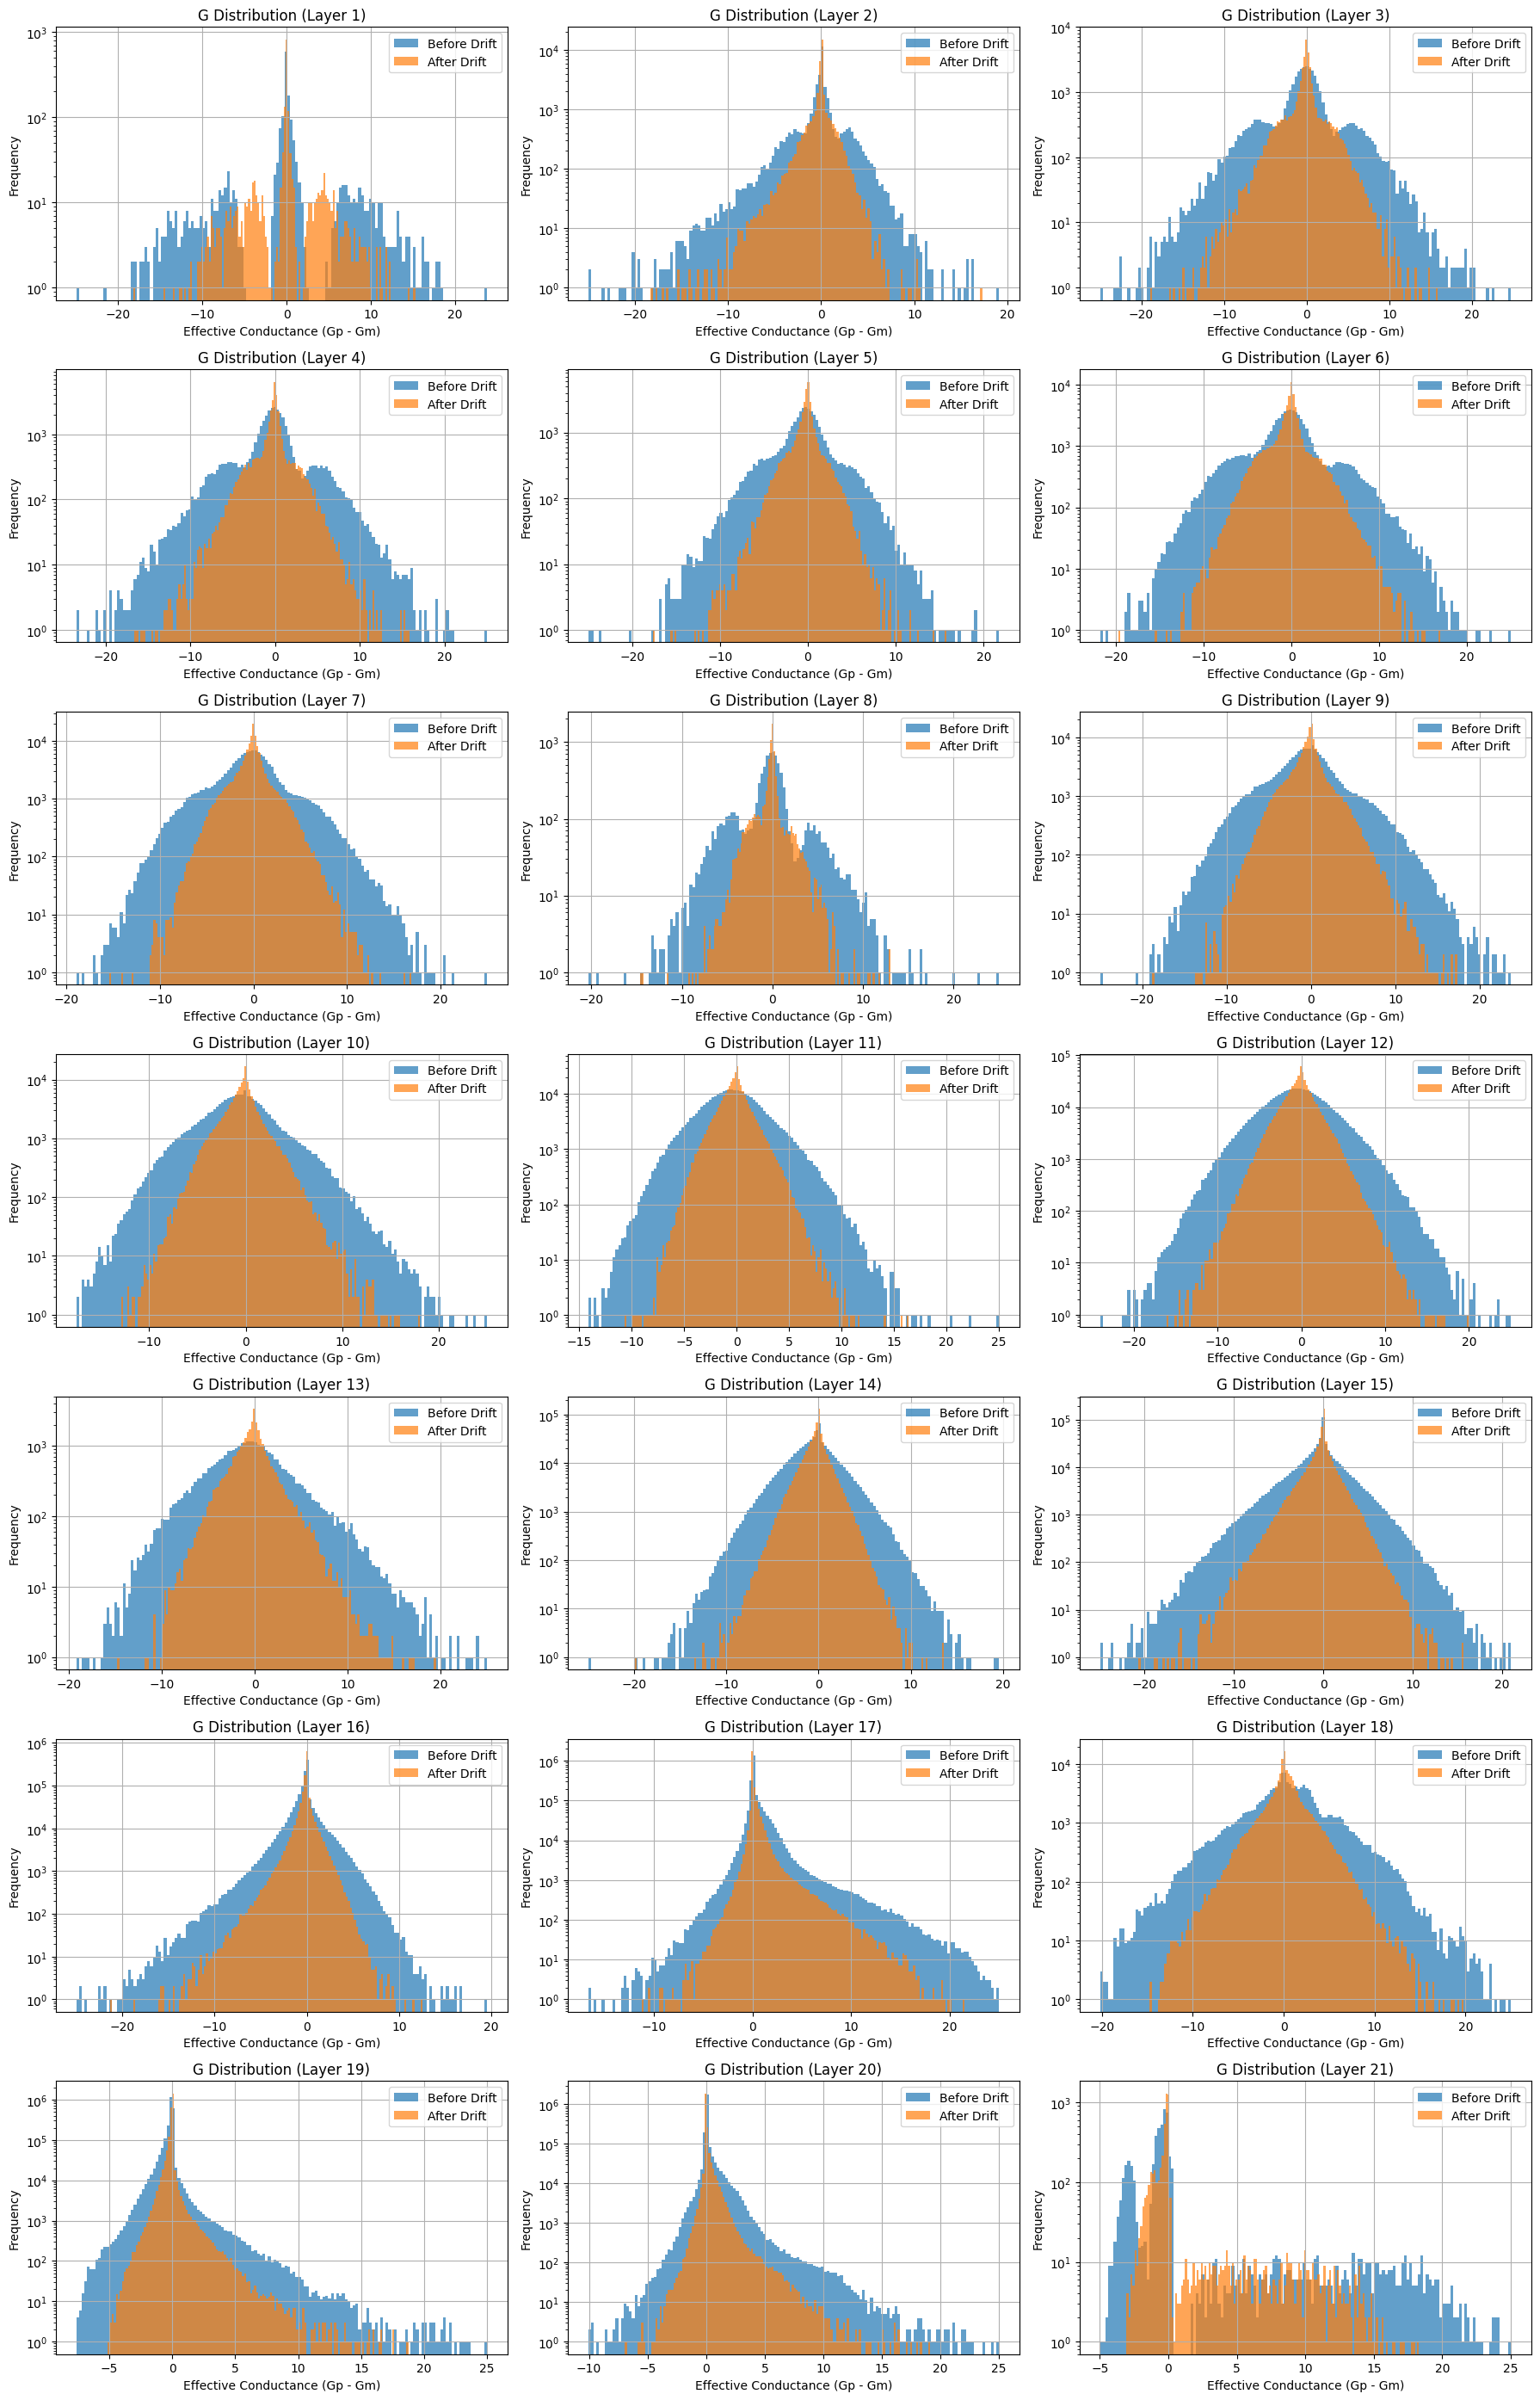

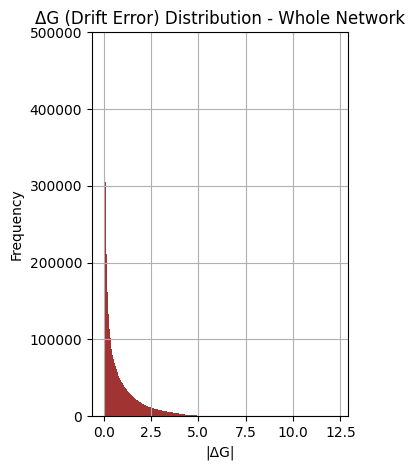

In [251]:
compute_and_plot_network_drift(finetuned_model, dataset="cifar10", gdc=False, t_seconds=9.33e7)

In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def compute_and_plot_layerwise_drift(model, dataset, gdc=True, ideal_io=True, t_seconds=3600*24*7):
    inf_model = InfModel(model, dataset, noise_list=[0, 0])
    rpu_config = inf_model.SetConfig(gdc=gdc, ideal_io=ideal_io)
    analog_model = inf_model.ConvertModel(gdc=gdc, ideal_io=ideal_io)

    noise_model = rpu_config.noise_model
    g_converter = noise_model.g_converter

    layerwise_delta_g = {}
    stats = []

    for name, param in analog_model.named_parameters():
        if "weight" in name and len(param.size()) > 1:
            weights = param.data.cpu()

            (gp, gm), _ = g_converter.convert_to_conductances(weights)

            gp_prog = noise_model.apply_programming_noise_to_conductance(gp)
            gm_prog = noise_model.apply_programming_noise_to_conductance(gm)

            nu_gp = noise_model.generate_drift_coefficients(gp_prog)
            nu_gm = noise_model.generate_drift_coefficients(gm_prog)

            gp_drifted = noise_model.apply_drift_noise_to_conductance(gp_prog, nu_gp, t_seconds)
            gm_drifted = noise_model.apply_drift_noise_to_conductance(gm_prog, nu_gm, t_seconds)

            g_init = gp_prog - gm_prog
            g_drifted = gp_drifted - gm_drifted
            delta_g = torch.abs(g_init - g_drifted).flatten().numpy()

            layerwise_delta_g[name] = delta_g
            stats.append((name, delta_g.mean(), delta_g.std()))

    # ==== 출력: 통계 요약 ====
    print(f"{'Layer':<40} | {'ΔG Mean':>10} | {'ΔG Std':>10}")
    print("-"*65)
    for name, mean, std in stats:
        print(f"{name:<40} | {mean:10.5f} | {std:10.5f}")

    # ==== 시각화: 레이어별 ΔG 분포 ====
    num_layers = len(layerwise_delta_g)
    cols = 2
    rows = (num_layers + 1) // cols

    plt.figure(figsize=(cols * 6, rows * 4))
    for i, (name, delta_g) in enumerate(layerwise_delta_g.items()):
        plt.subplot(rows, cols, i + 1)
        plt.hist(delta_g, bins=150, color='tomato', alpha=0.8)
        plt.title(f"ΔG Distribution\n{name}")
        plt.xlabel("|ΔG|")
        plt.ylabel("Frequency")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [190]:
# compute_and_plot_layerwise_drift(pruned_model, dataset="cifar10", t_seconds=100)


## G change (layerwise)

In [254]:
def compute_layer_drift_error(model, dataset, layer, gdc=True, ideal_io=True, t_seconds=3600*24*7):

    inf_model = InfModel(model, dataset, noise_list=[0,0])
    rpu_config = inf_model.SetConfig(gdc=gdc, ideal_io=ideal_io)
    analog_model = inf_model.ConvertModel(gdc=gdc, ideal_io=ideal_io)

    noise_model = rpu_config.noise_model
    g_converter = noise_model.g_converter
    
    all_g_init = []
    all_g_drifted = []
    all_delta_g = []
    total_drift_error = 0.0
    total_drift_error_ratio = 0.0
    total_g_init = 0.0
    total_g_drifted = 0.0
    total_nu = 0.0

    for name, param in analog_model.named_parameters():
        if 'weight' in name and name.startswith(layer) and len(param.size()) > 1:
            print(name)
            weights = param.data.cpu()

            # Conductance 변환
            (gp, gm), _ = g_converter.convert_to_conductances(weights)

            # Programming noise (optional, realistic)
            gp_prog = noise_model.apply_programming_noise_to_conductance(gp)
            gm_prog = noise_model.apply_programming_noise_to_conductance(gm)
            # gp_prog = gp
            # gm_prog = gm

            # Drift coefficient 생성
            nu_gp = noise_model.generate_drift_coefficients(gp_prog)
            nu_gm = noise_model.generate_drift_coefficients(gm_prog)

            # Drift 적용
            gp_drifted = noise_model.apply_drift_noise_to_conductance(gp_prog, nu_gp, t_seconds)
            gm_drifted = noise_model.apply_drift_noise_to_conductance(gm_prog, nu_gm, t_seconds)

            # ΔG 계산
            g_init = gp_prog - gm_prog
            g_drifted = gp_drifted - gm_drifted
            delta_g = torch.abs(g_init - g_drifted)
            # delta_g_ratio = torch.abs(delta_g / g_init)
            
            all_g_init.append(g_init.flatten())
            all_g_drifted.append(g_drifted.flatten())
            all_delta_g.append(delta_g.flatten())
            
            # total drift error
            drift_error = torch.sum(torch.abs(g_init - g_drifted)).item()
            total_drift_error += drift_error
            
            # total conductance
            # total_g_init += torch.sum(g_init).item()
            # total_g_drifted += torch.sum(g_drifted).item()
            total_g_init += torch.sum(torch.abs(g_init)).item()
            total_g_drifted += torch.sum(torch.abs(g_drifted)).item()

            # exclude zero conductance
            nonzero_mask = g_init != 0
            drift_error_ratio = torch.sum(delta_g[nonzero_mask] / g_init[nonzero_mask].abs()).item()
            total_drift_error_ratio += drift_error_ratio
            
            # calculate sum of nu
            total_nu += torch.sum(nu_gp).item() + torch.sum(nu_gm).item()
            
    # 전체 G 및 ΔG 모으기
    g_init_all = torch.cat(all_g_init).numpy()
    g_drifted_all = torch.cat(all_g_drifted).numpy()
    delta_g_all = torch.cat(all_delta_g).numpy()
    
    # for global drift compensation
    alpha = total_g_drifted / total_g_init
    total_drift_error_ratio_gdc = total_drift_error_ratio * alpha
    total_drift_error_gdc = total_drift_error * alpha
        
    # ==== 출력: 통계 요약 ====
    print("[TOTAL DRIFT STATS]")
    print(f"ΔG mean: {delta_g_all.mean():.6f}")
    print(f"ΔG std : {delta_g_all.std():.6f}")
    print(f"ΔG max : {delta_g_all.max():.6f}")
    # print(f"ΔG 99th percentile: {np.percentile(delta_g_all, 99):.6f}")
    print(f"Total drift error after {t_seconds}sec: {total_drift_error:.4e}")
    print(f"Total drift error ratio after {t_seconds}sec: {total_drift_error_ratio:.4e}")
    print(f"alpha: {alpha:.6f}")
    print(f"Total drift error ratio after {t_seconds}sec (GDC): {total_drift_error_ratio_gdc:.4e}")
    
    return total_drift_error, total_drift_error_gdc,total_drift_error_ratio, total_drift_error_ratio_gdc


In [255]:
t_seconds = 9.33e7
layer = 'conv1'
compute_layer_drift_error(finetuned_model, dataset="cifar10", layer=layer, t_seconds=t_seconds)

conv1.analog_module.shared_weights
[TOTAL DRIFT STATS]
ΔG mean: 1.422691
ΔG std : 1.973302
ΔG max : 8.510003
Total drift error after 93300000.0sec: 2.4584e+03
Total drift error ratio after 93300000.0sec: 9.4508e+02
alpha: 0.553172
Total drift error ratio after 93300000.0sec (GDC): 5.2279e+02


(2458.41064453125, 1359.9241787334174, 945.0814208984375, 522.7926742062158)

In [244]:
compute_layer_drift_error(vanilla_model, dataset="cifar10", layer='fc', t_seconds=t_seconds)

fc.analog_module.shared_weights
[TOTAL DRIFT STATS]
ΔG mean: 1.501922
ΔG std : 1.466378
ΔG max : 11.406697
Total drift error after 93300000.0sec: 7.6898e+03
Total drift error ratio after 93300000.0sec: 2.9399e+03


(7689.83935546875, 751216488.0612267, 2939.905029296875, 287197824.20049167)

In [228]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = '/FT_1e-06/best_model.pth'
dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
tuning_model = torch.load(f'{folder_path}/{model_name}', map_location="cpu")

compute_layer_drift_error(tuning_model, dataset="cifar10", layer=layer, t_seconds=t_seconds)

conv1.analog_module.shared_weights
[TOTAL DRIFT STATS]
ΔG mean: 1.289567
ΔG std : 2.047237
ΔG max : 9.050072
Total drift error after 93300000.0sec: 2.2284e+03
Total drift error ratio after 93300000.0sec: 8.2562e+02
alpha: 0.963874
Total drift error ratio after 93300000.0sec (GDC): 7.9579e+02


In [246]:
import torch
import os
import pandas as pd
from datetime import datetime

# 기본 경로 설정
base_dir = os.getcwd() + '/TestRun/'

# 폴더 이름 (pruning rate 변화)
folder_list = [
    'Test_2024-10-28_15-15_Resnet18_p0.3',
    'Test_2024-10-28_15-22_Resnet18_p0.4',
    'Test_2024-10-28_15-26_Resnet18_p0.5',
    'Test_2024-10-28_15-27_Resnet18_p0.6',
    'Test_2024-10-28_15-32_Resnet18_p0.7',
]

# 모델 이름 (fine-tuning 종류)
model_subdirs = ['FT_0.0005', 'FineTuning', 'FT_5e-05','FT_1e-05', 'FT_1e-06']

# 측정 대상 레이어와 시간
layer = 'fc'
t_seconds = 9.33e7

# 결과 저장
results = []

for folder in folder_list:
    for model_subdir in model_subdirs:
        folder_path = os.path.join(base_dir, folder, model_subdir)
        model_path = os.path.join(folder_path, 'best_model.pth')
        try:
            print(f"\n[INFO] Evaluating: {folder}/{model_subdir}")
            model = torch.load(model_path, map_location='cpu')

            # Get all 4 drift error ratios
            total_drift_error, total_drift_error_gdc, total_drift_error_ratio, total_drift_error_ratio_gdc = compute_layer_drift_error(
                model, dataset="cifar10", layer=layer, t_seconds=t_seconds
            )

            results.append({
                'Folder': folder,
                'FineTuning': model_subdir,
                'total_drift_error': total_drift_error,
                'total_drift_error_gdc': total_drift_error_gdc,
                'total_drift_error_ratio': total_drift_error_ratio,
                'total_drift_error_ratio_gdc': total_drift_error_ratio_gdc,    
            })

        except Exception as e:
            print(f"[ERROR] Failed on {folder}/{model_subdir}: {e}")

# 데이터프레임 변환
df = pd.DataFrame(results)

# 엑셀로 저장
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
excel_name = f"DriftErrorData_{timestamp}.xlsx"
df.to_excel(excel_name, index=False)


[INFO] Evaluating: Test_2024-10-28_15-15_Resnet18_p0.3/FT_0.0005
fc.analog_module.shared_weights
[TOTAL DRIFT STATS]
ΔG mean: 1.588344
ΔG std : 1.618961
ΔG max : 10.913272
Total drift error after 93300000.0sec: 8.1323e+03
Total drift error ratio after 93300000.0sec: 2.9587e+03

[INFO] Evaluating: Test_2024-10-28_15-15_Resnet18_p0.3/FineTuning
fc.analog_module.shared_weights
[TOTAL DRIFT STATS]
ΔG mean: 1.401017
ΔG std : 1.563932
ΔG max : 11.434230
Total drift error after 93300000.0sec: 7.1732e+03
Total drift error ratio after 93300000.0sec: 3.0261e+03

[INFO] Evaluating: Test_2024-10-28_15-15_Resnet18_p0.3/FT_5e-05
fc.analog_module.shared_weights
[TOTAL DRIFT STATS]
ΔG mean: 1.569179
ΔG std : 1.533610
ΔG max : 9.796861
Total drift error after 93300000.0sec: 8.0342e+03
Total drift error ratio after 93300000.0sec: 2.9385e+03

[INFO] Evaluating: Test_2024-10-28_15-15_Resnet18_p0.3/FT_1e-05
fc.analog_module.shared_weights
[TOTAL DRIFT STATS]
ΔG mean: 1.599668
ΔG std : 1.557532
ΔG max : 10

In [231]:
import torch
import os
import pandas as pd
from datetime import datetime

# 기본 경로 설정
base_dir = os.getcwd() + '/TestRun/'

# 폴더 이름 (pruning rate 변화)
folder_list = [
    'Test_2024-10-28_15-15_Resnet18_p0.3',
    'Test_2024-10-28_15-22_Resnet18_p0.4',
    'Test_2024-10-28_15-26_Resnet18_p0.5',
    'Test_2024-10-28_15-27_Resnet18_p0.6',
    'Test_2024-10-28_15-32_Resnet18_p0.7',
]

# 모델 이름 (fine-tuning 종류)
model_subdirs = ['FT_0.0005', 'FineTuning', 'FT_5e-05','FT_1e-05', 'FT_1e-06']

# 측정 대상 레이어와 시간
layer = 'fc'
t_seconds = 9.33e7

# 결과 저장
results = []

for folder in folder_list:
    for model_subdir in model_subdirs:
        folder_path = os.path.join(base_dir, folder, model_subdir)
        model_path = os.path.join(folder_path, 'best_model.pth')
        try:
            print(f"\n[INFO] Evaluating: {folder}/{model_subdir}")
            model = torch.load(model_path, map_location='cpu')

            # 수정된 함수에서 GDC 적용 drift error ratio 직접 반환
            drift_ratio_gdc = compute_layer_drift_error(
                model, dataset="cifar10", layer=layer, t_seconds=t_seconds
            )

            results.append({
                'Folder': folder,
                'FineTuning': model_subdir,
                'DriftErrorRatio_GDC': drift_ratio_gdc
            })

        except Exception as e:
            print(f"[ERROR] Failed on {folder}/{model_subdir}: {e}")
            results.append({
                'Folder': folder,
                'FineTuning': model_subdir,
                'DriftErrorRatio_GDC': None
            })

# 데이터프레임 변환
df = pd.DataFrame(results)

# 엑셀로 저장
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
excel_name = f"DriftErrorRatios_GDC_{timestamp}.xlsx"
df.to_excel(excel_name, index=False)
print(f"\n✅ [SAVED] Results saved to: {excel_name}")


[INFO] Evaluating: Test_2024-10-28_15-15_Resnet18_p0.3/FT_0.0005
fc.analog_module.shared_weights
[TOTAL DRIFT STATS]
ΔG mean: 1.585722
ΔG std : 1.585542
ΔG max : 11.801774
Total drift error after 93300000.0sec: 8.1189e+03
Total drift error ratio after 93300000.0sec: 2.9741e+03
alpha: -1.583735
Total drift error ratio after 93300000.0sec (GDC): -4.7102e+03

[INFO] Evaluating: Test_2024-10-28_15-15_Resnet18_p0.3/FineTuning
fc.analog_module.shared_weights
[TOTAL DRIFT STATS]
ΔG mean: 1.413669
ΔG std : 1.584243
ΔG max : 10.335756
Total drift error after 93300000.0sec: 7.2380e+03
Total drift error ratio after 93300000.0sec: 3.0527e+03
alpha: 2.362173
Total drift error ratio after 93300000.0sec (GDC): 7.2109e+03

[INFO] Evaluating: Test_2024-10-28_15-15_Resnet18_p0.3/FT_5e-05
fc.analog_module.shared_weights
[TOTAL DRIFT STATS]
ΔG mean: 1.583725
ΔG std : 1.570918
ΔG max : 11.781735
Total drift error after 93300000.0sec: 8.1087e+03
Total drift error ratio after 93300000.0sec: 2.9437e+03
alpha

## delta G rev.

In [266]:
def compute_total_drift_error_r1(model, dataset, gdc=True, ideal_io=True, t_seconds=3600*24*7):
    """ 
    Usage:
        t_seconds = 9.33e7
        compute_total_drift_error(finetuned_model, dataset="cifar10", t_seconds=t_seconds)
        
    """
    
    inf_model = InfModel(model, dataset, noise_list=[0,0])
    rpu_config = inf_model.SetConfig(gdc=gdc, ideal_io=ideal_io)
    analog_model = inf_model.ConvertModel(gdc=gdc, ideal_io=ideal_io)

    noise_model = rpu_config.noise_model
    g_converter = noise_model.g_converter

    # all_g_init = []
    # all_g_drifted = []
    # all_delta_g = []
    total_g_init = 0.0
    total_g_drifted = 0.0
    total_drift_err = 0.0
    total_drift_err_ratio = 0.0

    for name, param in analog_model.named_parameters():
        if "weight" in name and len(param.size()) > 1:
            weights = param.data.cpu()

            # weight to conductance
            (gp, gm), _ = g_converter.convert_to_conductances(weights)

            # Programming noise (optional, realistic)
            # gp_prog = noise_model.apply_programming_noise_to_conductance(gp)
            # gm_prog = noise_model.apply_programming_noise_to_conductance(gm)
            gp_prog = gp
            gm_prog = gm

            # Drift coefficient
            nu_gp = noise_model.generate_drift_coefficients(gp_prog)
            nu_gm = noise_model.generate_drift_coefficients(gm_prog)

            # after drift 
            gp_drifted = noise_model.apply_drift_noise_to_conductance(gp_prog, nu_gp, t_seconds)
            gm_drifted = noise_model.apply_drift_noise_to_conductance(gm_prog, nu_gm, t_seconds)
            
            # calculate delta G
            delta_gp = gp_prog - gp_drifted 
            delta_gm = gm_prog - gm_drifted
            
            # Create masks for non-zero conductances
            nonzero_gp = (gp_prog != 0)
            nonzero_gm = (gm_prog != 0)
            delta_gp_ratio = (delta_gp[nonzero_gp] / gp_prog[nonzero_gp])
            delta_gm_ratio = (delta_gm[nonzero_gm] / gm_prog[nonzero_gm])
            
            # total conductance = Gp + Gm
            total_g_init += torch.sum(gp_prog).item() + torch.sum(gm_prog).item()
            total_g_drifted += torch.sum(gp_drifted).item() + torch.sum(gm_drifted).item()
            
            # total drift error = (Gp-Gp_drifted) + (Gm-Gm_drifted)
            drift_err = torch.sum(delta_gp).item() + torch.sum(delta_gm).item()
            total_drift_err += drift_err
            
            # total drift error ratio = drift_err / G
            drift_err_ratio = torch.sum(delta_gp_ratio).item() + torch.sum(delta_gm_ratio).item()
            total_drift_err_ratio += drift_err_ratio
            
    # # 전체 G 및 ΔG 모으기
    # g_init_all = torch.cat(all_g_init).numpy()
    # g_drifted_all = torch.cat(all_g_drifted).numpy()
    # delta_g_all = torch.cat(all_delta_g).numpy()
    
    # for global drift compensation
    alpha = total_g_drifted / total_g_init
    total_drift_err_gdc = total_drift_err * alpha
    total_drift_err_ratio_gdc = total_drift_err_ratio * alpha

    # ==== 출력: 통계 요약 ====
    print("[TOTAL DRIFT STATS]")
    # print(f"ΔG mean: {delta_g_all.mean():.6f}")
    # print(f"ΔG std : {delta_g_all.std():.6f}")
    print(f"Total drift error after {t_seconds}sec: {total_drift_err:.4e}")
    print(f"Total drift error ratio after {t_seconds}sec: {total_drift_err_ratio:.4e}")
    print(f"alpha: {alpha:.5f}")
    print(f"Total drift error after {t_seconds}sec (GDC): {total_drift_err_gdc:.4e}")
    print(f"Total drift error ratio after {t_seconds}sec (GDC): {total_drift_err_ratio_gdc:.4e}")
    
    return total_drift_err, total_drift_err_gdc, total_drift_err_ratio, total_drift_err_ratio_gdc

In [264]:
t_seconds = 9.33e7
compute_total_drift_error_r1(finetuned_model, dataset="cifar10", t_seconds=t_seconds)

[TOTAL DRIFT STATS]
Total drift error after 93300000.0sec: 5.5853e+06
Total drift error ratio after 93300000.0sec: 7.4702e+06
alpha: 0.45126
Total drift error after 93300000.0sec (GDC): 2.5205e+06
Total drift error ratio after 93300000.0sec (GDC): 3.3710e+06


In [265]:
t_seconds = 9.33e7
compute_total_drift_error_r1(vanilla_model, dataset="cifar10", t_seconds=t_seconds)

[TOTAL DRIFT STATS]
Total drift error after 93300000.0sec: 7.5521e+06
Total drift error ratio after 93300000.0sec: 7.1193e+06
alpha: 0.42990
Total drift error after 93300000.0sec (GDC): 3.2467e+06
Total drift error ratio after 93300000.0sec (GDC): 3.0606e+06


In [267]:
import torch
import os
import pandas as pd
from datetime import datetime

# 기본 경로 설정
base_dir = os.getcwd() + '/TestRun/'

# 폴더 이름 (pruning rate 변화)
folder_list = [
    'Test_2024-10-28_15-15_Resnet18_p0.3',
    'Test_2024-10-28_15-22_Resnet18_p0.4',
    'Test_2024-10-28_15-26_Resnet18_p0.5',
    'Test_2024-10-28_15-27_Resnet18_p0.6',
    'Test_2024-10-28_15-32_Resnet18_p0.7',
]

# 모델 이름 (fine-tuning 종류)
model_subdirs = ['FT_0.0005', 'FineTuning', 'FT_5e-05','FT_1e-05', 'FT_1e-06']

# 측정 대상 레이어와 시간
layer = 'fc'
t_seconds = 9.33e7

# 결과 저장
results = []

for folder in folder_list:
    for model_subdir in model_subdirs:
        folder_path = os.path.join(base_dir, folder, model_subdir)
        model_path = os.path.join(folder_path, 'best_model.pth')
        try:
            print(f"\n[INFO] Evaluating: {folder}/{model_subdir}")
            model = torch.load(model_path, map_location='cpu')

            # Get all 4 drift error ratios
            total_drift_error, total_drift_error_gdc, total_drift_error_ratio, total_drift_error_ratio_gdc = compute_total_drift_error_r1(
                model, dataset="cifar10", t_seconds=t_seconds
            )

            results.append({
                'Folder': folder,
                'FineTuning': model_subdir,
                'total_drift_error': total_drift_error,
                'total_drift_error_gdc': total_drift_error_gdc,
                'total_drift_error_ratio': total_drift_error_ratio,
                'total_drift_error_ratio_gdc': total_drift_error_ratio_gdc,    
            })

        except Exception as e:
            print(f"[ERROR] Failed on {folder}/{model_subdir}: {e}")

# 데이터프레임 변환
df = pd.DataFrame(results)

# 엑셀로 저장
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
excel_name = f"DriftErrorData_{timestamp}.xlsx"
df.to_excel(excel_name, index=False)


[INFO] Evaluating: Test_2024-10-28_15-15_Resnet18_p0.3/FT_0.0005
[TOTAL DRIFT STATS]
Total drift error after 93300000.0sec: 1.4436e+07
Total drift error ratio after 93300000.0sec: 6.6139e+06
alpha: 0.46495
Total drift error after 93300000.0sec (GDC): 6.7118e+06
Total drift error ratio after 93300000.0sec (GDC): 3.0751e+06

[INFO] Evaluating: Test_2024-10-28_15-15_Resnet18_p0.3/FineTuning
[TOTAL DRIFT STATS]
Total drift error after 93300000.0sec: 4.9059e+06
Total drift error ratio after 93300000.0sec: 7.6112e+06
alpha: 0.46158
Total drift error after 93300000.0sec (GDC): 2.2645e+06
Total drift error ratio after 93300000.0sec (GDC): 3.5132e+06

[INFO] Evaluating: Test_2024-10-28_15-15_Resnet18_p0.3/FT_5e-05
[TOTAL DRIFT STATS]
Total drift error after 93300000.0sec: 3.1974e+06
Total drift error ratio after 93300000.0sec: 7.6770e+06
alpha: 0.41583
Total drift error after 93300000.0sec (GDC): 1.3296e+06
Total drift error ratio after 93300000.0sec (GDC): 3.1923e+06

[INFO] Evaluating: Test_

## delta G layerwise rev

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from network import InfModel

In [7]:
def compute_layer_drift_error_r1(model, dataset, layer, gdc=True, ideal_io=True, t_seconds=3600*24*7):

    inf_model = InfModel(model, dataset, noise_list=[0,0])
    rpu_config = inf_model.SetConfig(gdc=gdc, ideal_io=ideal_io)
    analog_model = inf_model.ConvertModel(gdc=gdc, ideal_io=ideal_io)

    noise_model = rpu_config.noise_model
    g_converter = noise_model.g_converter
    
    all_g_init = []
    all_g_drifted = []
    all_delta_g = []
    total_drift_err = 0.0
    total_drift_err_ratio = 0.0
    total_g_init = 0.0
    total_g_drifted = 0.0
    total_nu = 0.0

    for name, param in analog_model.named_parameters():
        if 'weight' in name and name.startswith(layer) and len(param.size()) > 1:
            print(name)
            weights = param.data.cpu()

            # Conductance 변환
            (gp, gm), _ = g_converter.convert_to_conductances(weights)

            # Programming noise (optional, realistic)
            # gp_prog = noise_model.apply_programming_noise_to_conductance(gp)
            # gm_prog = noise_model.apply_programming_noise_to_conductance(gm)
            gp_prog = gp
            gm_prog = gm

            # Drift coefficient 생성
            nu_gp = noise_model.generate_drift_coefficients(gp_prog)
            nu_gm = noise_model.generate_drift_coefficients(gm_prog)

            # Drift 적용
            gp_drifted = noise_model.apply_drift_noise_to_conductance(gp_prog, nu_gp, t_seconds)
            gm_drifted = noise_model.apply_drift_noise_to_conductance(gm_prog, nu_gm, t_seconds)

            # calculate delta G
            delta_gp = gp_prog - gp_drifted 
            delta_gm = gm_prog - gm_drifted
            
            # Create masks for non-zero conductances
            nonzero_gp = (gp_prog != 0)
            nonzero_gm = (gm_prog != 0)
            delta_gp_ratio = (delta_gp[nonzero_gp] / gp_prog[nonzero_gp])
            delta_gm_ratio = (delta_gm[nonzero_gm] / gm_prog[nonzero_gm])
            
            # total conductance = Gp + Gm
            total_g_init += torch.sum(gp_prog).item() + torch.sum(gm_prog).item()
            total_g_drifted += torch.sum(gp_drifted).item() + torch.sum(gm_drifted).item()
            
            # total drift error = (Gp-Gp_drifted) + (Gm-Gm_drifted)
            drift_err = torch.sum(delta_gp).item() + torch.sum(delta_gm).item()
            total_drift_err += drift_err
            
            # total drift error ratio = drift_err / G
            drift_err_ratio = torch.sum(delta_gp_ratio).item() + torch.sum(delta_gm_ratio).item()
            total_drift_err_ratio += drift_err_ratio
            
            # calculate sum of nu
            total_nu += torch.sum(nu_gp).item() + torch.sum(nu_gm).item()
            
    # 전체 G 및 ΔG 모으기
    # g_init_all = torch.cat(all_g_init).numpy()
    # g_drifted_all = torch.cat(all_g_drifted).numpy()
    # delta_g_all = torch.cat(all_delta_g).numpy()
    
    # for global drift compensation
    alpha = total_g_drifted / total_g_init
    total_drift_err_gdc = total_drift_err * alpha
    total_drift_err_ratio_gdc = total_drift_err_ratio * alpha
        
    # ==== 출력: 통계 요약 ====
    print("[TOTAL DRIFT STATS]")
    # print(f"ΔG mean: {delta_g_all.mean():.6f}")
    # print(f"ΔG std : {delta_g_all.std():.6f}")
    # print(f"ΔG max : {delta_g_all.max():.6f}")
    # print(f"ΔG 99th percentile: {np.percentile(delta_g_all, 99):.6f}")
    print(f"Total drift error after {t_seconds}sec: {total_drift_err:.4e}")
    print(f"Total drift error ratio after {t_seconds}sec: {total_drift_err_ratio:.4e}")
    print(f"alpha: {alpha:.5f}")
    print(f"Total drift error after {t_seconds}sec (GDC): {total_drift_err_gdc:.4e}")
    print(f"Total drift error ratio after {t_seconds}sec (GDC): {total_drift_err_ratio_gdc:.4e}")
    
    return total_drift_err, total_drift_err_gdc,total_drift_err_ratio, total_drift_err_ratio_gdc


In [8]:
compute_layer_drift_error_r1(vanilla_model, dataset="cifar10", layer='conv1', t_seconds=9.33e7)

conv1.analog_module.shared_weights
[TOTAL DRIFT STATS]
Total drift error after 93300000.0sec: 3.2831e+03
Total drift error ratio after 93300000.0sec: 9.8157e+02
alpha: 0.53166
Total drift error after 93300000.0sec (GDC): 1.7455e+03
Total drift error ratio after 93300000.0sec (GDC): 5.2186e+02


(3283.119873046875, 1745.49884724818, 981.5684814453125, 521.8593042927487)

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from network import InfModel

# 기본 경로 설정
base_dir = os.getcwd() + '/TestRun/'

# 폴더 이름 (pruning rate 변화)
folder_list = [
    # 'Test_2024-10-28_15-15_Resnet18_p0.3',
    # 'Test_2024-10-28_15-22_Resnet18_p0.4',
    # 'Test_2024-10-28_15-26_Resnet18_p0.5',
    # 'Test_2024-10-28_15-27_Resnet18_p0.6',
    # 'Test_2024-10-28_15-32_Resnet18_p0.7',
    'Test_2025-04-01_20-26_Resnet18_p0.8',
    'Test_2025-04-01_20-33_Resnet18_p0.9',
]

# 모델 이름 (fine-tuning 종류)
# model_subdirs = ['FT_0.0005', 'FineTuning', 'FT_5e-05','FT_1e-05', 'FT_1e-06']
model_subdirs = ['FT_0.0005_50', 'FT_0.0001_50', 'FT_5e-05_50','FT_1e-05_50', 'FT_1e-06_50'] # for p0.8, p0.9

# 측정 대상 레이어와 시간
layer = 'fc'
t_seconds = 9.33e7

# 결과 저장
results = []

for folder in folder_list:
    for model_subdir in model_subdirs:
        folder_path = os.path.join(base_dir, folder, model_subdir)
        model_path = os.path.join(folder_path, 'best_model.pth')
        try:
            print(f"\n[INFO] Evaluating: {folder}/{model_subdir}")
            model = torch.load(model_path, map_location='cpu')

            # Get all 4 drift error ratios
            total_drift_error, total_drift_error_gdc, total_drift_error_ratio, total_drift_error_ratio_gdc = compute_layer_drift_error_r1(
                model, dataset="cifar10", layer=layer, t_seconds=t_seconds
            )

            results.append({
                'Folder': folder,
                'FineTuning': model_subdir,
                'total_drift_error': total_drift_error,
                'total_drift_error_gdc': total_drift_error_gdc,
                'total_drift_error_ratio': total_drift_error_ratio,
                'total_drift_error_ratio_gdc': total_drift_error_ratio_gdc,    
            })

        except Exception as e:
            print(f"[ERROR] Failed on {folder}/{model_subdir}: {e}")

# 데이터프레임 변환
df = pd.DataFrame(results)

# 엑셀로 저장
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
excel_name = f"DriftErrorData_{timestamp}.xlsx"
df.to_excel(excel_name, index=False)


[INFO] Evaluating: Test_2025-04-01_20-26_Resnet18_p0.8/FT_0.0005_50
fc.analog_module.shared_weights
[TOTAL DRIFT STATS]
Total drift error after 93300000.0sec: 5.7703e+03
Total drift error ratio after 93300000.0sec: 3.1759e+03
alpha: 0.53759
Total drift error after 93300000.0sec (GDC): 3.1020e+03
Total drift error ratio after 93300000.0sec (GDC): 1.7073e+03

[INFO] Evaluating: Test_2025-04-01_20-26_Resnet18_p0.8/FT_0.0001_50
fc.analog_module.shared_weights
[TOTAL DRIFT STATS]
Total drift error after 93300000.0sec: 5.0586e+03
Total drift error ratio after 93300000.0sec: 3.2168e+03
alpha: 0.54167
Total drift error after 93300000.0sec (GDC): 2.7401e+03
Total drift error ratio after 93300000.0sec (GDC): 1.7424e+03

[INFO] Evaluating: Test_2025-04-01_20-26_Resnet18_p0.8/FT_5e-05_50
fc.analog_module.shared_weights
[TOTAL DRIFT STATS]
Total drift error after 93300000.0sec: 5.7894e+03
Total drift error ratio after 93300000.0sec: 3.1092e+03
alpha: 0.53344
Total drift error after 93300000.0sec (

## finetuned model G 변환 문제 해결

In [2]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'FineTuning/best_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
finetuned_model = torch.load(f'{folder_path}/{model_name}')

In [55]:
for name, param in finetuned_model.named_parameters():
    if "weight" in name and len(param.size()) > 1: 
        print(name)

conv1.weight
layer1.0.conv1.weight
layer1.0.conv2.weight
layer1.1.conv1.weight
layer1.1.conv2.weight
layer2.0.conv1.weight
layer2.0.conv2.weight
layer2.0.downsample.0.weight
layer2.1.conv1.weight
layer2.1.conv2.weight
layer3.0.conv1.weight
layer3.0.conv2.weight
layer3.0.downsample.0.weight
layer3.1.conv1.weight
layer3.1.conv2.weight
layer4.0.conv1.weight
layer4.0.conv2.weight
layer4.0.downsample.0.weight
layer4.1.conv1.weight
layer4.1.conv2.weight
fc.weight


In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from network import InfModel

def convert_weights_to_conductance(model, rpu_config):
    conductance_list_fc = []
    conductance_list_conv = []

    min_gp_fc, min_gm_fc = None, None
    min_gp_conv, min_gm_conv = None, None

    for name, param in model.named_parameters():
        # print(f"[DEBUG] {name}: max={param.data.max()}, mean={param.data.mean()}")
        if "weight" in name and len(param.size()) > 1:  # Conv / FC layer만 처리
            weights = param.data.cpu()
            
            # print(f"[DEBUG] Weight stats: max={weights.max()}, min={weights.min()}, mean={weights.mean()}")
            
            # Conductance 변환 수행
            conductance_pair = rpu_config.noise_model.g_converter.convert_to_conductances(weights)
            # print(f"[DEBUG] Converted to Conductance: {conductance_pair[0][0].shape}")  # shape of Gp
            gp, gm = conductance_pair[0]  # conductance_pair는 (gp, gm), params 반환
            # print(f"[DEBUG] Gp nonzero: {torch.count_nonzero(gp)}, Gm nonzero: {torch.count_nonzero(gm)}")

            # 0이 아닌 값들만 필터링
            gp_nonzero = gp[gp > 0]  # 0보다 큰 값만 선택
            gm_nonzero = gm[gm > 0]  # 0보다 큰 값만 선택

            if "fc" in name or weights.shape[0] <= 10:  # Fully Connected Layer
                conductance_list_fc.append((gp.flatten(), gm.flatten()))

                # 최소값 업데이트
                if gp_nonzero.numel() > 0:
                    min_gp_fc = gp_nonzero.min().item() if min_gp_fc is None else min(min_gp_fc, gp_nonzero.min().item())
                if gm_nonzero.numel() > 0:
                    min_gm_fc = gm_nonzero.min().item() if min_gm_fc is None else min(min_gm_fc, gm_nonzero.min().item())

            else:  # Convolutional Layer
                conductance_list_conv.append((gp.flatten(), gm.flatten()))

                # 최소값 업데이트
                if gp_nonzero.numel() > 0:
                    min_gp_conv = gp_nonzero.min().item() if min_gp_conv is None else min(min_gp_conv, gp_nonzero.min().item())
                if gm_nonzero.numel() > 0:
                    min_gm_conv = gm_nonzero.min().item() if min_gm_conv is None else min(min_gm_conv, gm_nonzero.min().item())

    print(f"Min Nonzero Gp (FC): {min_gp_fc}, Min Nonzero Gm (FC): {min_gm_fc}")
    print(f"Min Nonzero Gp (Conv): {min_gp_conv}, Min Nonzero Gm (Conv): {min_gm_conv}")

    return conductance_list_fc, conductance_list_conv

# Conductance distribution plot
def plot_conductance_distribution(model, model_name, gdc:bool, ideal_io:bool):
    inf_model = InfModel(model, "cifar10")
    rpu_config = inf_model.SetConfig(gdc=gdc, ideal_io=ideal_io)
    analog_model = inf_model.ConvertModel(gdc=gdc, ideal_io=ideal_io)

    conductance_list_fc, conductance_list_conv = convert_weights_to_conductance(analog_model, rpu_config)

    gp_fc_all = np.concatenate([gp for gp, _ in conductance_list_fc]) if conductance_list_fc else np.array([])
    gm_fc_all = np.concatenate([gm for _, gm in conductance_list_fc]) if conductance_list_fc else np.array([])
    
    gp_conv_all = np.concatenate([gp for gp, _ in conductance_list_conv]) if conductance_list_conv else np.array([])
    gm_conv_all = np.concatenate([gm for _, gm in conductance_list_conv]) if conductance_list_conv else np.array([])
    print(f"[DEBUG] gp_fc_all size: {gp_fc_all.size}, gp_conv_all size: {gp_conv_all.size}")

    fig, axes = plt.subplots(1,2, figsize=(12, 5))
    # 전체 제목 (중앙)
    fig.suptitle(model_name, fontsize=14, fontweight='bold')  

    # FC 레이어 Conductance Plot
    axes[0].hist(gp_fc_all, bins=150, alpha=1, label="Gp (FC)")
    axes[0].hist(-gm_fc_all, bins=150, alpha=0.7, label="Gm (FC)")
    axes[0].set_title('G Distribution (FC)')
    axes[0].set_xlabel('Conductance Value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, axis='y')
    axes[0].set_yscale('log')

    # Conv 레이어 Conductance Plot
    axes[1].hist(gp_conv_all, bins=500, alpha=1, label="Gp (Conv)")
    axes[1].hist(-gm_conv_all, bins=500, alpha=0.7, label="Gm (Conv)")
    axes[1].set_title('G Distribution (Conv)')
    axes[1].set_xlabel('Conductance Value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True, axis='y')
    axes[1].set_yscale('log')
    # axes[1].set_xlim(-0.1,10)

    plt.tight_layout()
    plt.show()

Min Nonzero Gp (FC): 0.0012116378638893366, Min Nonzero Gm (FC): 2.826629497576505e-06
Min Nonzero Gp (Conv): 2.1019476964872256e-42, Min Nonzero Gm (Conv): 4.414090162623174e-42
[DEBUG] gp_fc_all size: 5120, gp_conv_all size: 11159232


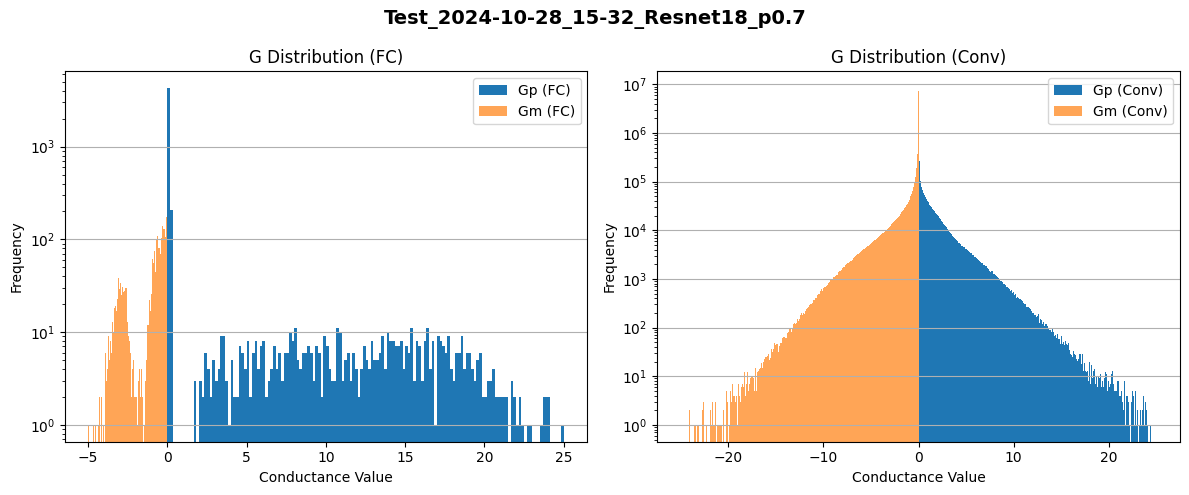

In [15]:
folder_name = 'Test_2024-10-28_15-32_Resnet18_p0.7'
model_name = 'FineTuning/best_model.pth'

dir_name = os.getcwd() + '/TestRun/'
folder_path = dir_name + folder_name
finetuned_model = torch.load(f'{folder_path}/{model_name}', map_location="cpu")

plot_conductance_distribution(finetuned_model, folder_name, True, True)